In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import tensorflow.keras as keras
import os
import time

1. preprocessing data
2. build model
2.1 encoder
2.2 attention
2.3 decoder
2.4 loss & optimizer
2.5 train
3. evalution
3.1 given sentence, return translated results
3.2 visualize results (attention)

In [13]:
en_spa_file_path = './spa.txt'

# unicode 转 ascii
import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sequence = 'Then what?'
sp_sentence = '¿Entonces qué?'

print(unicode_to_ascii(en_sequence))
print(unicode_to_ascii(sp_sentence))

Then what?
¿Entonces que?


In [5]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    # 字符串小写并去除头尾空格字符
    
    s = re.sub(r"([?.!,¿])", r" \1 ", s)  # 所有标点符号前后加空格
    s = re.sub(r'[" "]+', " ", s)   # 空格去重
    
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)  # 除了26字母和5个标点符号，其他全部替换成空格
    
    s = s.rstrip().strip()  # 去掉前后空格
    
    s = '<start> ' + s + ' <end>'  # 加上 <start> <end> 标记
    return s

print(preprocess_sentence(en_sequence))
print(preprocess_sentence(sp_sentence))

<start> then what ? <end>
<start> ¿ entonces que ? <end>


In [14]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs]
    return zip(*preprocessed_sentence_pairs)  # 下面演示 zpi(*a) 的用法

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


In [10]:
a = [(1, 2), (3, 4), (5, 6)]
c, d = zip(*a)
print(c, d)

(1, 3, 5) (2, 4, 6)


In [16]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
        # num_words 词表总数，None 不限制
        # filter 黑名单
        # split 按照 ' ' 空格分割
    lang_tokenizer.fit_on_texts(lang)
    # 统计词频，生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)  # 
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [17]:
from sklearn.model_selection import train_test_split
# 将数据集拆分成训练、验证、测试集
input_train, input_eval = train_test_split(input_tensor, test_size=0.2)
output_train, output_eval = train_test_split(output_tensor, test_size=0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [18]:
# 文本转 id
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('{:d} --> {:s}'.format(t, tokenizer.index_word[t]))

convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)
print()

1 --> <start>
135 --> ve
10 --> a
22 --> por
520 --> ello
3 --> .
2 --> <end>

1 --> <start>
53 --> how
41 --> did
6 --> you
1104 --> decide
7 --> ?
2 --> <end>



In [21]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)   

In [22]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1   78  160 ...    0    0    0]
 [   1   12  147 ...    0    0    0]
 [   1   10   25 ...    0    0    0]
 ...
 [   1   29   16 ...    0    0    0]
 [   1    5 2982 ...    0    0    0]
 [   1   13  141 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    4 1204   80 1898    3    2    0    0    0    0]
 [   1    4   65  250   20    3    2    0    0    0    0]
 [   1    4  257    5  118    6    3    2    0    0    0]
 [   1   28  103    3    2    0    0    0    0    0    0]
 [   1   82  268    5  688    7    2    0    0    0    0]
 [   1   97    4  185    9   25    7    2    0    0    0]
 [   1   31   13  115   17    3    2    0    0    0    0]
 [   1   14  238   52   61  188    3    2    0    0    0]
 [   1   16   38  368  107   39    3    2    0    0    0]
 [   1    4   96   20   14  145    3    2    0    0    0]
 [   1    4   47   15   40    9  292    3    2    0    0]
 [   1  187    8  183    3    2    0    0    0    0    0]
 [   1

In [23]:
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [25]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    # 创建一个全是 0 的隐藏层状态
    def initializer_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units,
                  units, batch_size)
sample_hidden = encoder.initializer_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print("sample_output.shape: ", sample_output.shape)
print("sample_hidden.shape: ", sample_hidden.shape)

sample_output.shape:  (64, 16, 1024)
sample_hidden.shape:  (64, 1024)


In [33]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(
            decoder_hidden, 1)
        
        # before V : (batch_size, length, units)
        # after V : (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)
            )
        )
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights

attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)

print("attention_results.shape: ", attention_results.shape)
print("attention_weights.shape: ", attention_weights.shape)
        

attention_results.shape:  (64, 1024)
attention_weights.shape:  (64, 16, 1)


In [36]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                return_sequences = True,
                                return_state = True,
                                recurrent_initializer = 'glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        
        # 用于注意力
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat(
            [tf.expand_dims(context_vector, 1), x], axis = -1
        )
        
        # output.shape: [batch_size, 1, decoding_units]
        # state.shape: [batch_size, decoding_units]
        output, state = self.gru(combined_x)
        
        # output.shape: [batch_size, decoding_units]
        output = tf.squeeze(output, [1])
        
        # output.shape: [batch_size, vocab_size]
        output = self.fc(output)
        
        return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)),
                  sample_hidden,
                  sample_output)

decoder_output, decoder_hidden, decoder_aw = outputs

print("decoder_output.shape: ", decoder_output.shape)
print("decoder_hidden.shape: ", decoder_hidden.shape)
print("decoder_attention_weights.shape: ", decoder_aw.shape)

decoder_output.shape:  (64, 4929)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape:  (64, 16, 1)


![seq2seq模型结构图](seq2seq.png)

In [37]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 0 为padding ，设置 mask 对应 0 的部分为 False ，非 0 的部分为 True
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)  # 对 mask 数据类型转换为 loss_ 的数据类型， True -> 1, False -> 0
    loss_ *= mask
    
    return tf.reduce_mean(loss_)   

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [44]:
@tf.function
def train_step(input, target, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(input, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        # 教师强制 - 将目标词作为下一个输入
        for t in range(0, target.shape[1] - 1):
            decoding_input = tf.expand_dims(target[:, t], 1)
            
            # 将编码器输出 （enc_output） 传送至解码器
            predictions, decoding_hidden, _ = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(target[:, t+1], predictions)
        
        batch_loss = loss / int(target.shape[0])   # 不同长度loss叠加次数不同，需要平均
        variables = encoder.trainable_variables + decoder.trainable_variables  # 合并需要训练的参数
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

In [45]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

last_checkpoint = tf.train.latest_checkpoint(checkpoint_prefix)
if(last_checkpoint != None):
    checkpoint.restore(last_checkpoint)
for epoch in  range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initializer_hidden_state()
    total_loss = 0
    
    for (batch, (input, target)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy()))
    
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7681
Epoch 1 Batch 100 Loss 0.3985
Epoch 1 Batch 200 Loss 0.3232
Epoch 1 Batch 300 Loss 0.3347
Epoch 1 Batch 400 Loss 0.2987
Epoch 1 Loss 0.349167
Time take for 1 epoch 857.5870106220245 sec

Epoch 2 Batch 0 Loss 0.3044
Epoch 2 Batch 100 Loss 0.2924
Epoch 2 Batch 200 Loss 0.2967
Epoch 2 Batch 300 Loss 0.2723
Epoch 2 Batch 400 Loss 0.2792
Epoch 2 Loss 0.284684
Time take for 1 epoch 814.8302602767944 sec

Epoch 3 Batch 0 Loss 0.2867
Epoch 3 Batch 100 Loss 0.2769
Epoch 3 Batch 200 Loss 0.2639
Epoch 3 Batch 300 Loss 0.2613
Epoch 3 Batch 400 Loss 0.2492
Epoch 3 Loss 0.261291
Time take for 1 epoch 867.7419862747192 sec

Epoch 4 Batch 0 Loss 0.2338
Epoch 4 Batch 100 Loss 0.2346
Epoch 4 Batch 200 Loss 0.2471
Epoch 4 Batch 300 Loss 0.2457
Epoch 4 Batch 400 Loss 0.2196
Epoch 4 Loss 0.244603
Time take for 1 epoch 1007.5364348888397 sec

Epoch 5 Batch 0 Loss 0.2414
Epoch 5 Batch 100 Loss 0.2284
Epoch 5 Batch 200 Loss 0.2451
Epoch 5 Batch 300 Loss 0.2353
Epoch 5 Batch 400 Los

In [60]:
encoder.save_weights('seq2seq_encoder.h5')
decoder.save_weights('seq2seq_decoder.h5')

In [56]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen = max_length_input, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    # decoding_input.shape: (1, 1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for  t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_outputs)
        
        # attention_weights.shape: (batch_size, input_length, 1) (1, 16, 1)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size) (1, 4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input =  tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = font_dict,)
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')),
                                        :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '),
                   results.split(' '))

Input: <start> esta muy frio aqui <end>
Predicted translation: i m a good boy . <end> 


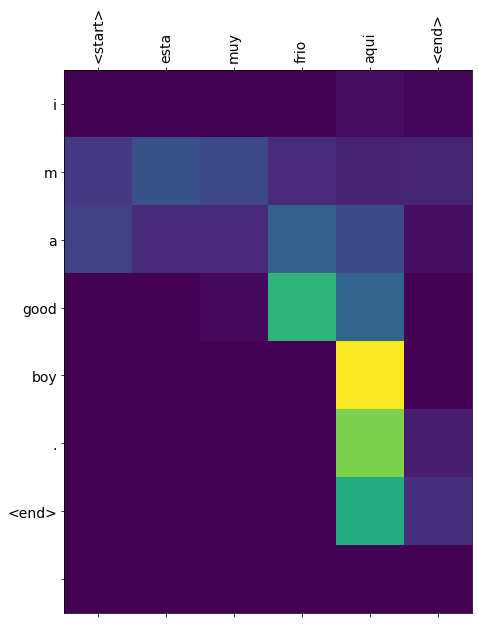

In [57]:
translate(u'Está muy frío aquí')   # 翻译西班牙语 '这里很冷'

Input: <start> hace frio aqui <end>
Predicted translation: i am not my word . <end> 


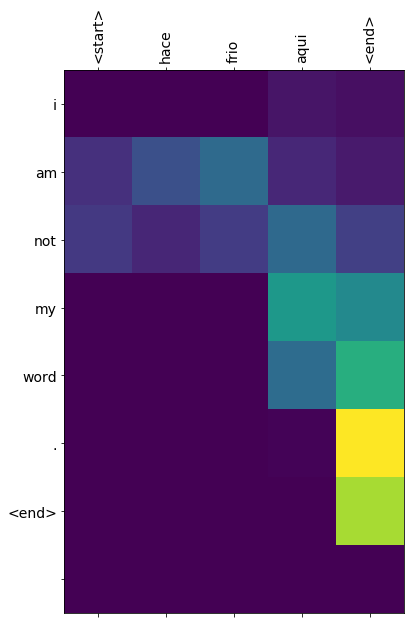

In [59]:
translate(u'hace frío aquí')

Input: <start> no estoy bien <end>
Predicted translation: i m not rich . <end> 


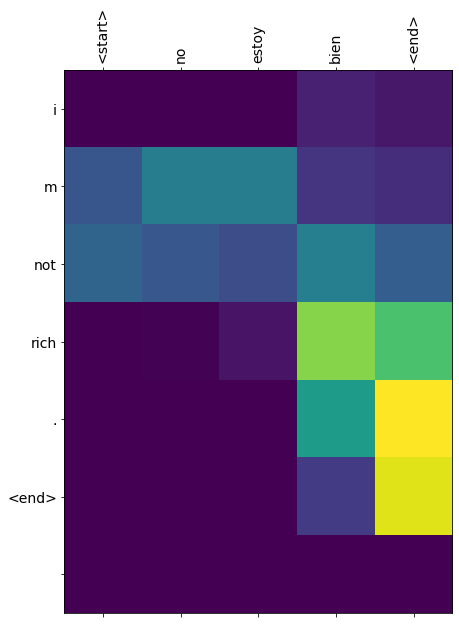

In [62]:
translate(u'no estoy bien')